<a href="https://colab.research.google.com/github/AV-Gorshkov/Python_netology/blob/main/PY_10_%D0%9F%D0%BE%D0%B8%D1%81%D0%BA_%D0%B8%D0%B7%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание**

Выберите ряд, на котором происходит аномалия. Примените к нему все 4 способа поиска анамолий.

In [5]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import matplotlib.font_manager
from collections import deque, defaultdict
from sklearn import svm
import warnings

# warnings.filterwarnings(action='once')
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Выбран [временной ряд](https://archive.ics.uci.edu/ml/datasets/Vicon+Physical+Action+Data+Set) из набора, полученного от датчикой движений. В данном случае от датчика движений при размахивании.

In [7]:
#  загрузка данных
param = r'/content/drive/My Drive/Нетология/ML/Временные_ряды/Поиск_аномалий/'

file = f'{param}Waving.txt'

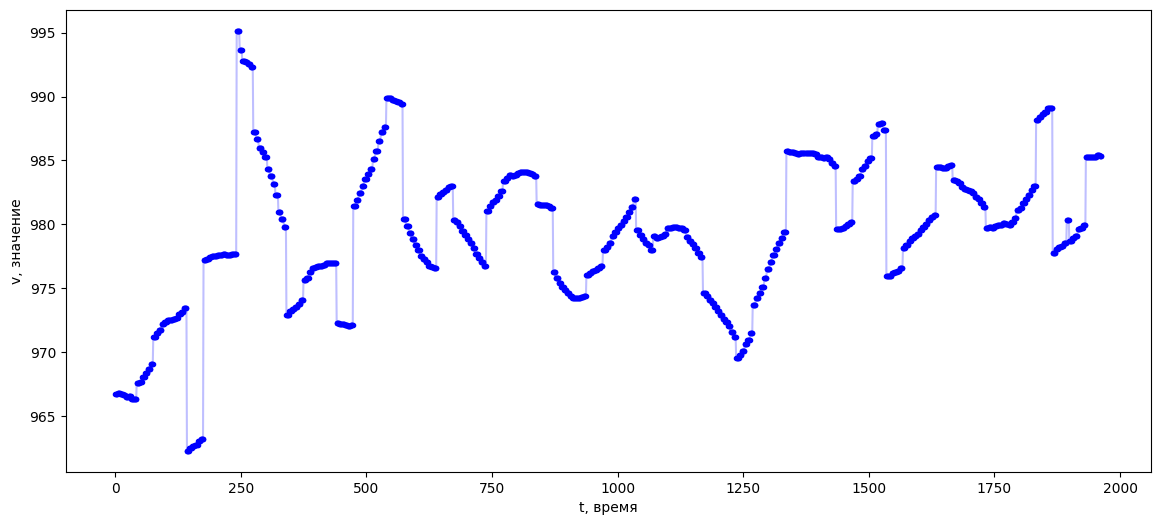

In [8]:
def get_series(fname, number):
    lists = []
    with open(fname, "r") as f:
        for line in f:
            nums = line.replace("  ", " ").split(" ")
            lists.append([float(num) for num in nums])
    arr = np.array(lists).T
    return arr[min(len(arr) - 1, number)]


y = get_series(file, 4)
plt.figure(figsize=(14, 6))
plt.plot(y, 'b.')
plt.plot(y, 'b-', alpha=0.25)
plt.xlabel("t, время")
plt.ylabel("v, значение")
plt.show()

1. Используем детектор на мат. ожидании.

Данный детектор довольно примитивен и у него только 1 настраиваемый параметр - порог. Попробуем с несколькими его значениями.

In [9]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0

    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count

    def check(self, new_signal_value):
        threshold_level = self.mean * self.threshold

        return np.abs(new_signal_value - self.mean) > threshold_level

def simulate(detector, signal, title):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)

    plt.figure(figsize=(14, 6))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.25)
    if len(stop_points):
        plt.title(f"{title}. Найдено стоп-точек: {len(stop_points)}.")
    else:
        plt.title(f"{title}. Стоп-точки не обнаружены.")
    if stop_points:
        for i in range(len(stop_points)):
            plt.vlines(x=stop_points[i], ymin=np.min(signal), ymax=np.max(signal),
                colors='r', linestyles='dotted')
    plt.xlabel("t, время")
    plt.ylabel("v, значение")
    plt.show()

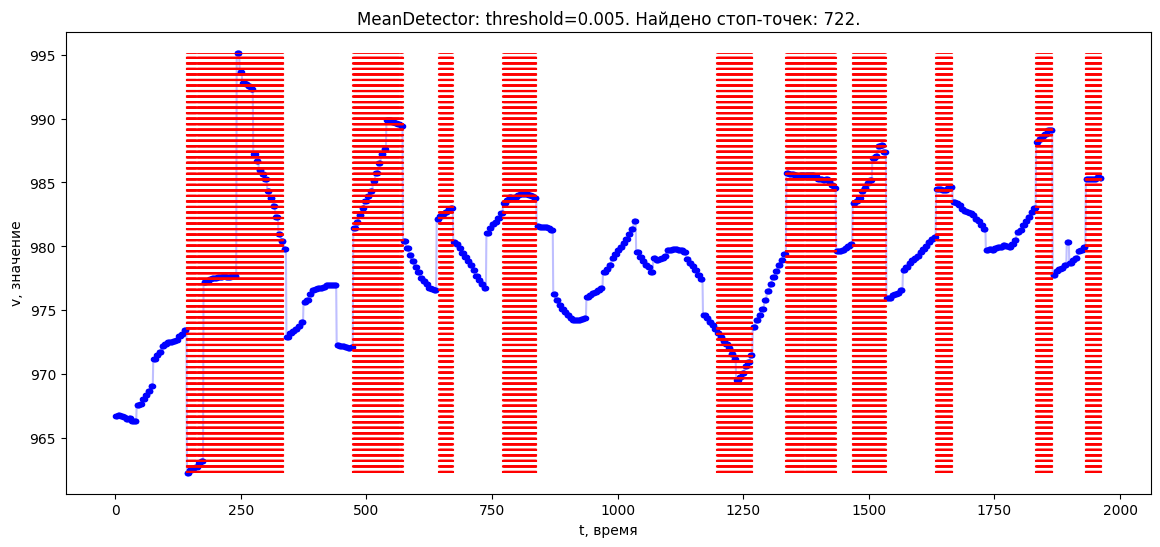

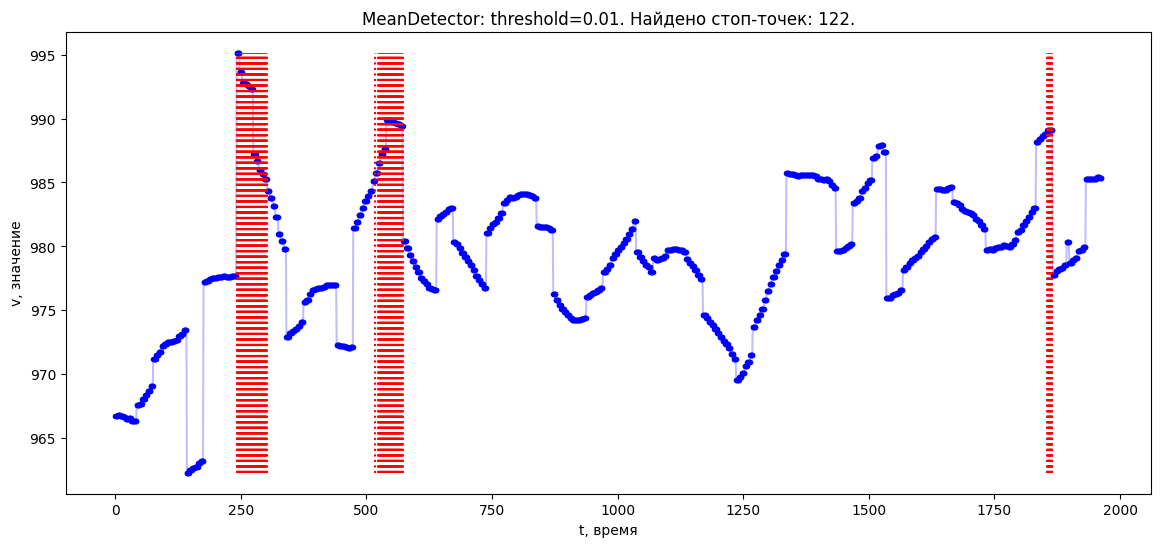

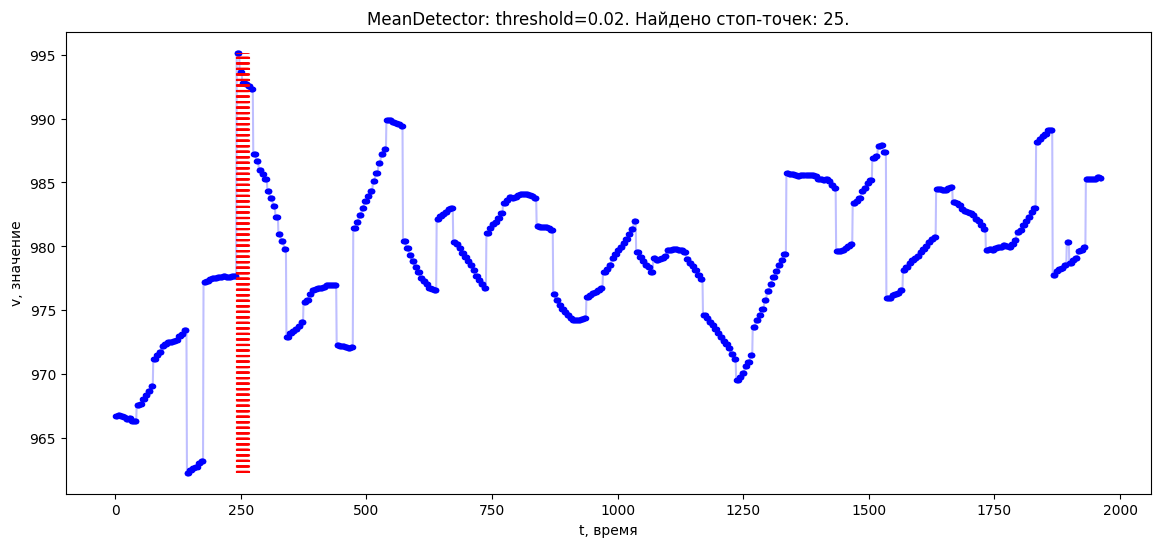

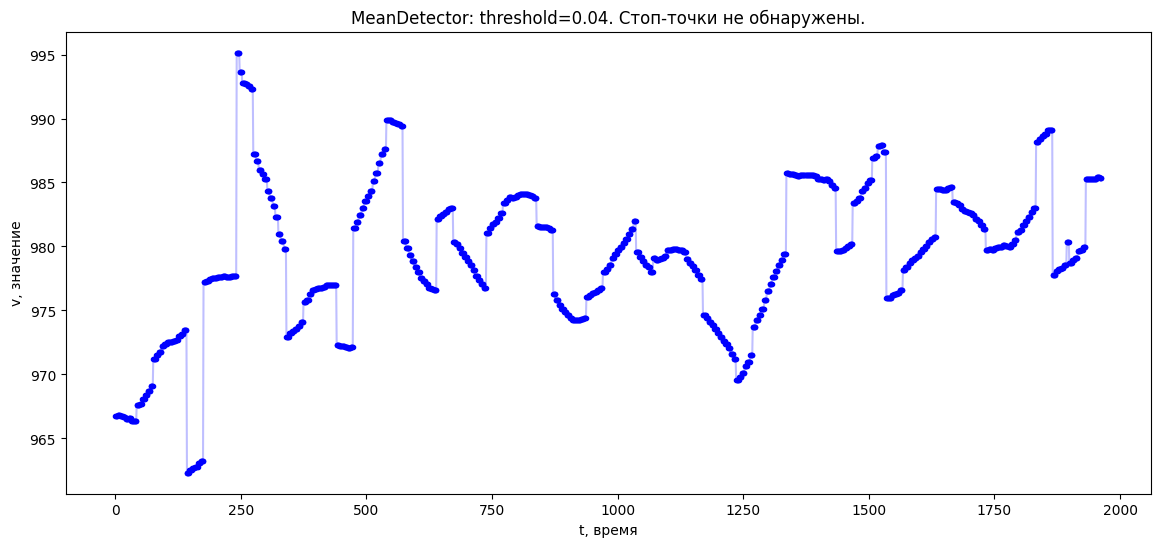

In [13]:
for thr in [0.005, 0.01, 0.02, 0.04]:
    simulate(MeanDetector(thr), y, f"MeanDetector: threshold={thr}")

Как видим, в зависимости от значений порога получились разные результаты. При 0.005 датчик отреагировал как на сильные изменения, так и на меньшие. При 0.2 детекция лучше, уже реакция на сильное изменение. Однако, в области. При пороге 0.04 датчик вовсе не реагирует.

2. Используем детектор Z-score.

In [14]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0
        self.g_mean = 0.0  # global mean
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan

    def update(self, new_signal_value):
        x = new_signal_value

        # Добавляем в окно
        self.window.append(x)

        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm
        g_std = np.sqrt(s / (self.k+1))

        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE

        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s

        self.k += 1

    def check(self, new_signal_value):
        return np.abs(self.z_score) > self.threshold

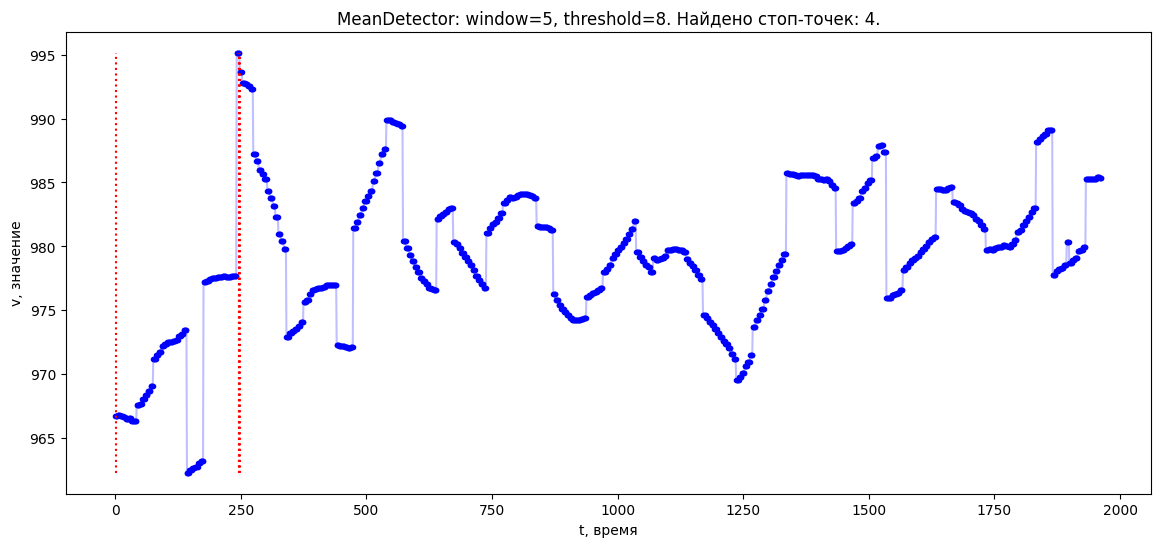

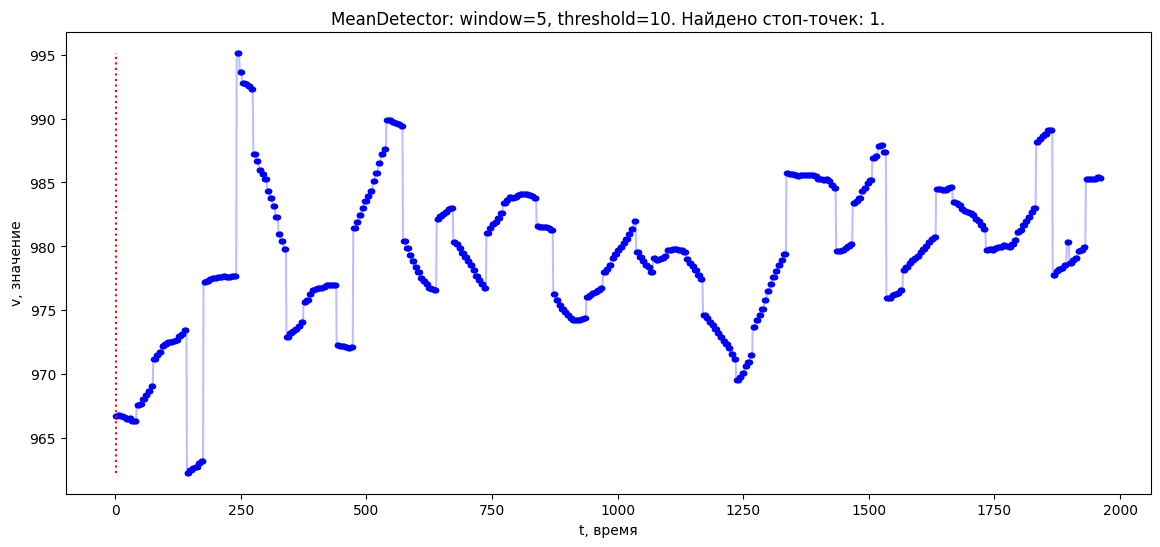

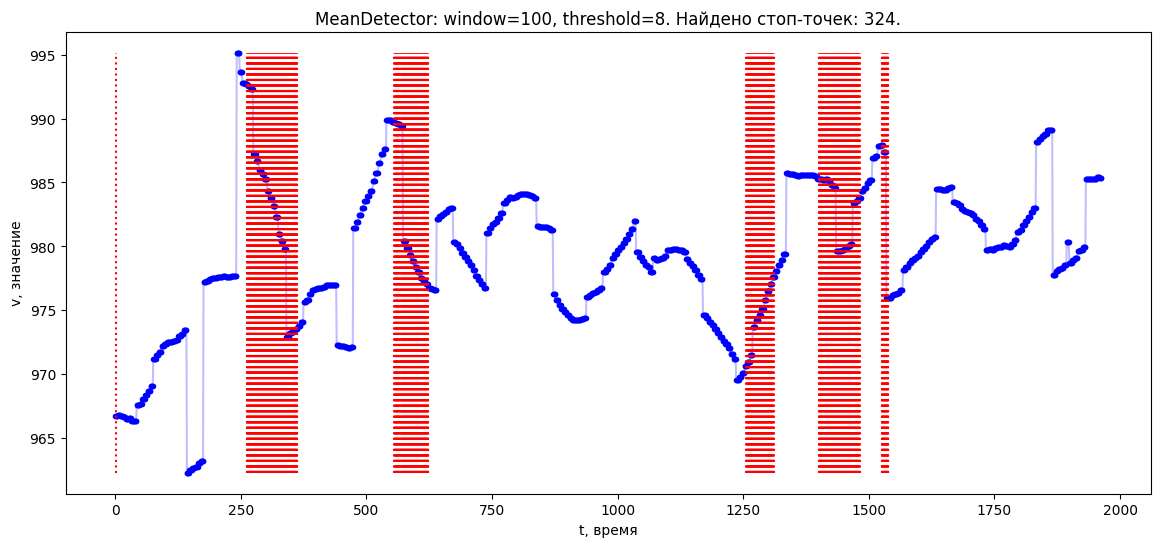

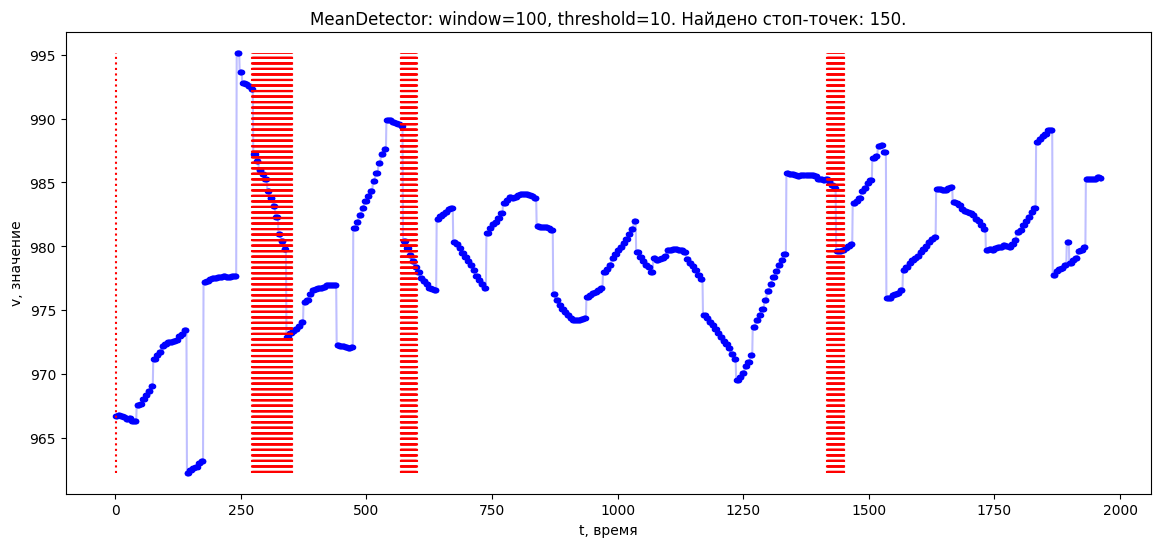

In [15]:
for window, thr in [(5, 8), (5, 10), (100, 8), (100, 10)]:
    simulate(ZScoreDetector(window, thr), y, f"MeanDetector: window={window}, threshold={thr}")

На графиках видно, что при размере окна 5 видна небольшая задержка отклика.

При размере окна 100 значение порога повлияло смещение начала сигнализирования на длительность сигнализирования. При пороге 8 срабатывание было раньше и сигнализирование длилось дольше, чем при пороге 8.

Если сравнивать данный индикатор с предыдущим, то при окне 5 и пороге 10 он показал более лучший результат: длительность сигнализирования минимальна, однако, присутствует задержка. Оба индикатора отреагировали только на рост.

3. Используем детектор на основе кумулятивных сумм.

In [16]:



__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    t = range(x.size)
    plt.figure(figsize=(14, 6))
    plt.plot(t, x, 'b-', lw=2)
    if len(ta):
        plt.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10, label='Начало')
        if ending:
            plt.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10, label='Окончание')
        plt.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5, label='Стоп-точка')
        plt.legend(loc='best', framealpha=.5, numpoints=1)
        plt.title(f"detect_cusum: threshold={threshold}, drift={drift}. Найдено стоп-точек: {len(tai)}.")
    else:
        plt.title(f"detect_cusum: threshold={threshold}, drift={drift}. Стоп-точки не обнаружены.")
    plt.xlim(-.01*x.size, x.size*1.01-1)
    plt.xlabel("t, время")
    plt.ylabel("v, значение")
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    plt.ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    plt.tight_layout()
    plt.show()

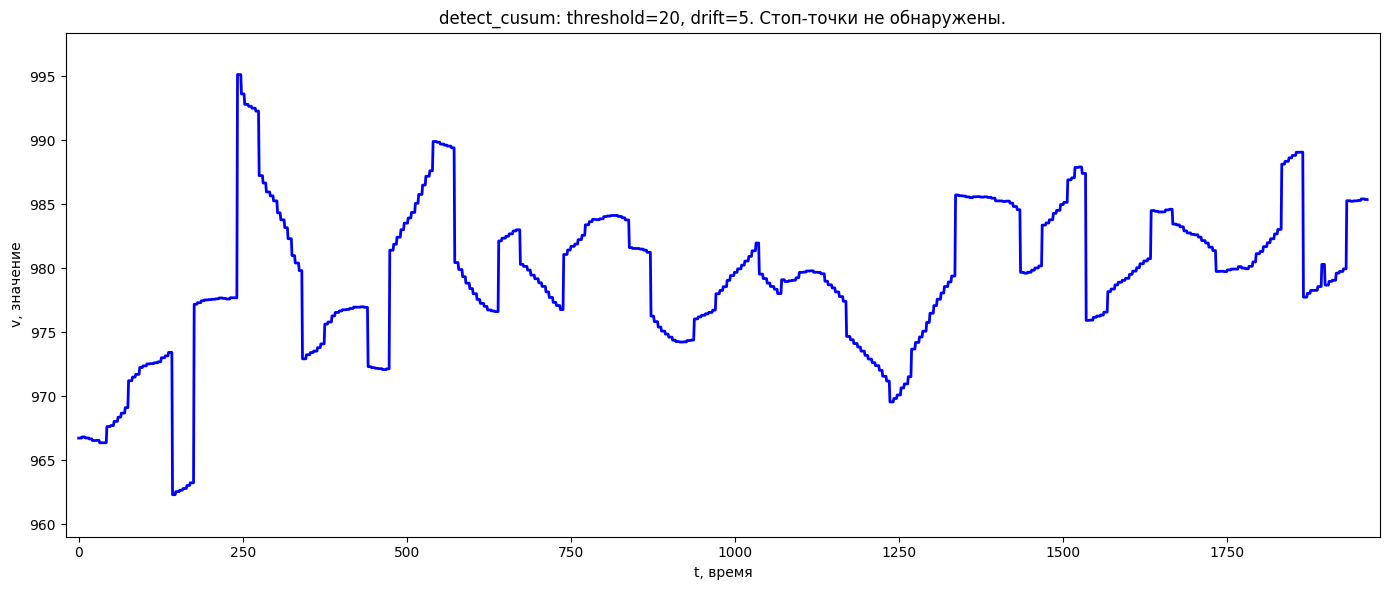

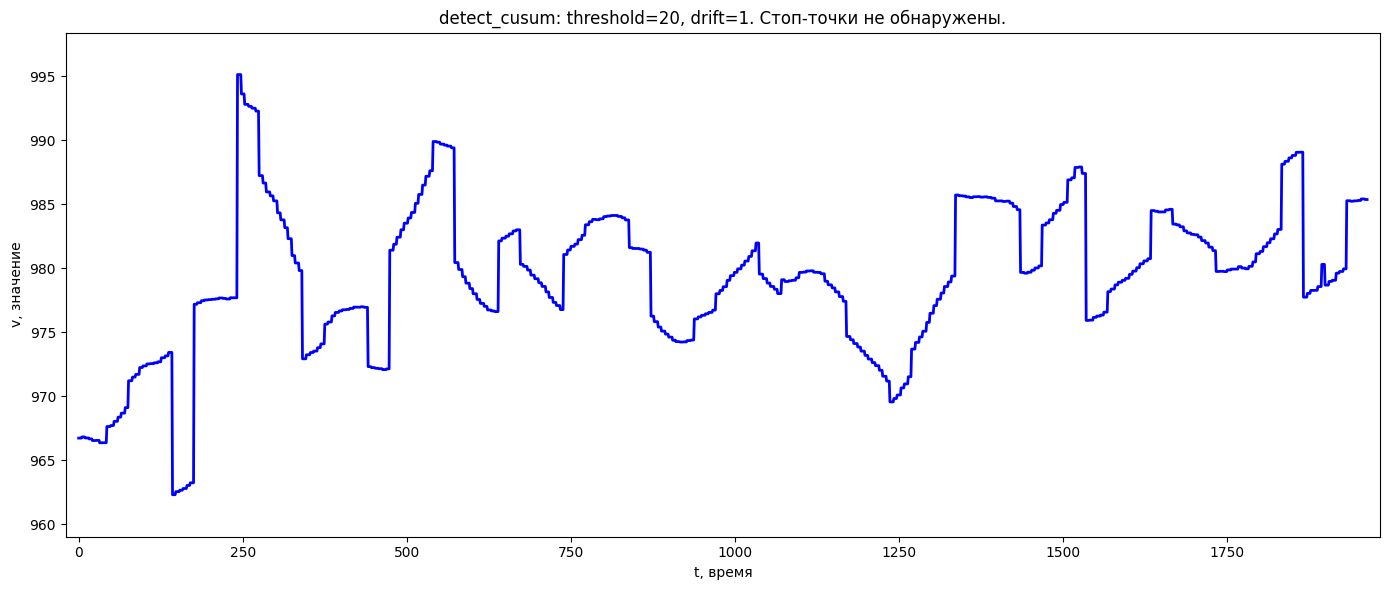

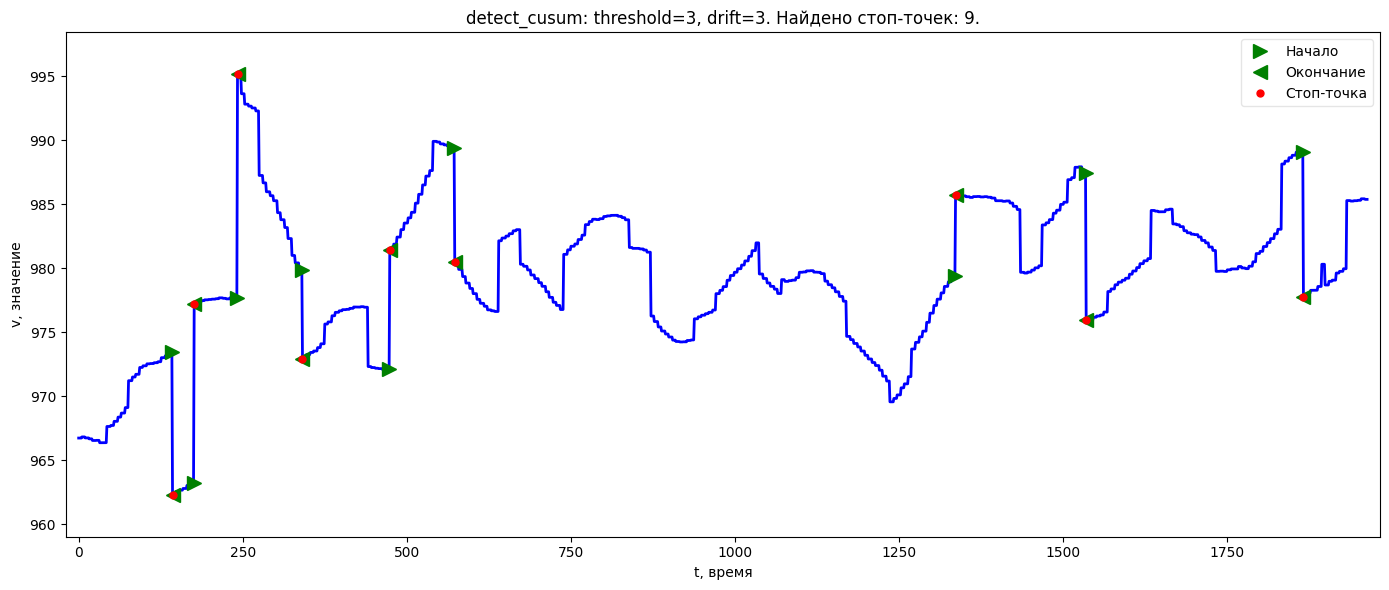

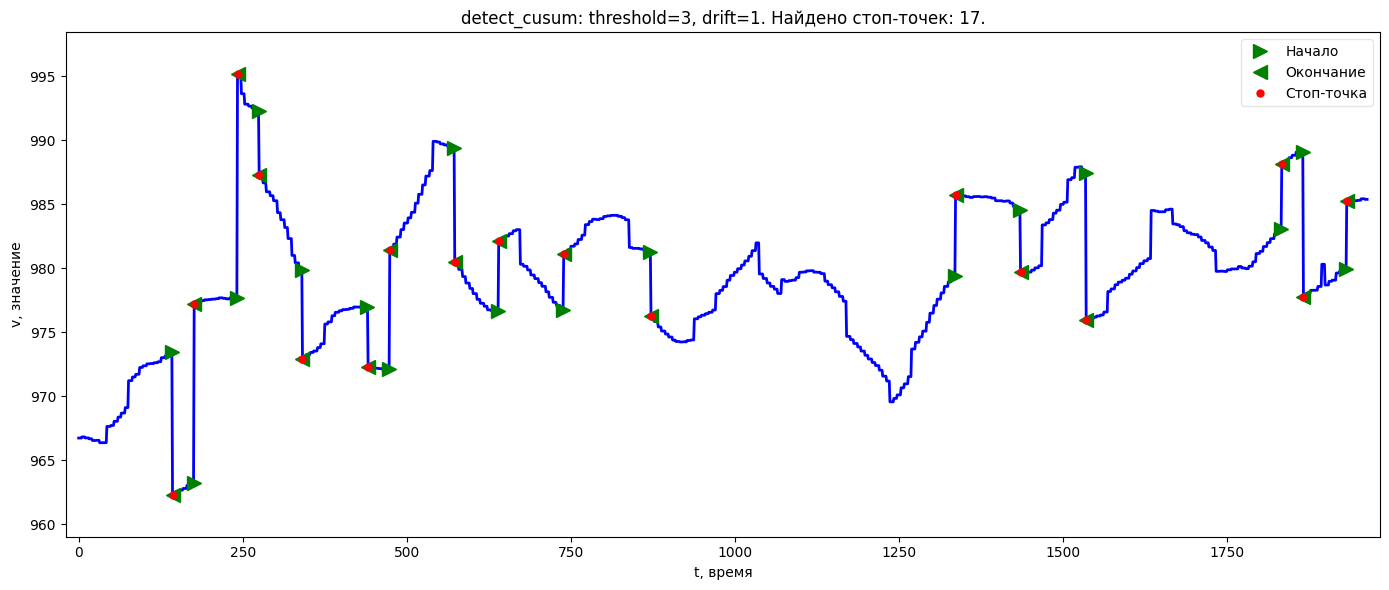

In [17]:
for thr, drift in [(20, 5), (20, 1), (3, 3), (3, 1)]:
    detect_cusum(y, thr, drift, True, True);

У детектора 2 параметра: порог и дрейф.

При пороге 20 видно детектор не срабатывает. При уменьшении порога до 3 появляются ложные срабатывания. Так, при дрейфе 3 наблюдается 1 ложное срабатывание, а при дрейфе 1 их уже 2.

Данный детектор на основе куммулятиных сумм отработал лучше предыдущих детекторов: он обнаружил изменения, при этом указал начало и окончание этих изменений.

4. Используем детектор OneClass SVM.

Разделим выборку на тренировочную и тестовую, обучим детектор и получим предсказание (детект) для обеих выборок.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm


def train_test_split(data, test=0.3):
    train_cnt = int(len(data) * (1 - test))
    return data[:train_cnt], data[train_cnt:]

def ocsvm_detector(y, gamma=0.01, nu=0.01):
    ym = y.reshape((-1, 1))
    y_train, y_test = train_test_split(ym, 0.3)
    total_len = len(ym)
    train_len = len(y_train)
    test_len = len(y_test)

    clf = svm.OneClassSVM(nu=nu, gamma=gamma)
    clf.fit(y_train)
    y_pred_train = clf.predict(y_train)
    y_pred_test = clf.predict(y_test)

    false_positive_train = []
    false_positive_test = []

    for i, t in enumerate(y_pred_train):
        if t != 1:
            el = float(ym[i])
            false_positive_train.append((i, el))

    for i, t in enumerate(y_pred_test):
        if t != 1:
            el = float( ym[i + train_len])
            false_positive_test.append((i + train_len, el))

    false_positive_train = np.array(false_positive_train)
    false_positive_test = np.array(false_positive_test)

    ls_count = 1500
    ls = np.linspace(0.997 * np.min(ym), 1.003 * np.max(ym), ls_count).reshape(-1, 1)
    Z = clf.decision_function(ls)
    Z = np.vstack((Z, Z))
    ls = ls.reshape(ls_count)

    plt.figure(figsize=(14, 6))
    plt.contourf([0, total_len], ls, Z.T, cmap=plt.cm.PuBu)
    plt.contour([0, total_len], ls, Z.T, levels=[0], linewidths=10, colors='darkred')
    plt.plot(range(train_len), ym[:train_len], 'wo', linewidth=10, label="Train point")
    plt.plot(range(train_len), ym[:train_len], 'w-', linewidth=2, label="Train line")
    plt.plot(range(train_len, total_len), ym[train_len:], 'bo', linewidth=10, label="Test point")
    plt.plot(range(train_len - 1, total_len), ym[train_len - 1:], 'b-', linewidth=2, label="Test line")
    plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go', label="Train FP")
    plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'yo', label="Test FP")
    plt.xlabel("t, время")
    plt.ylabel("v, значение")
    stop_points_cnt = len(false_positive_train) + len(false_positive_test)
    if stop_points_cnt:
        plt.title(f"ocsvm_detector: gamma={gamma}, nu={nu}. Найдено стоп-точек: {stop_points_cnt}.")
    else:
        plt.title(f"ocsvm_detector: gamma={gamma}, nu={nu}. Стоп-точки не обнаружены.")
    plt.legend()
    plt.show()

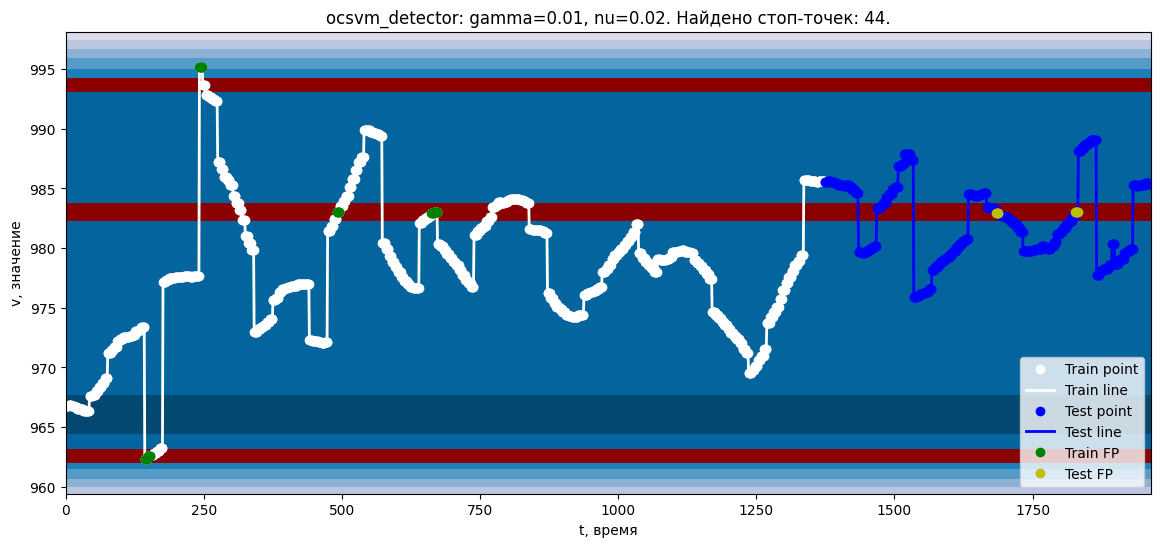

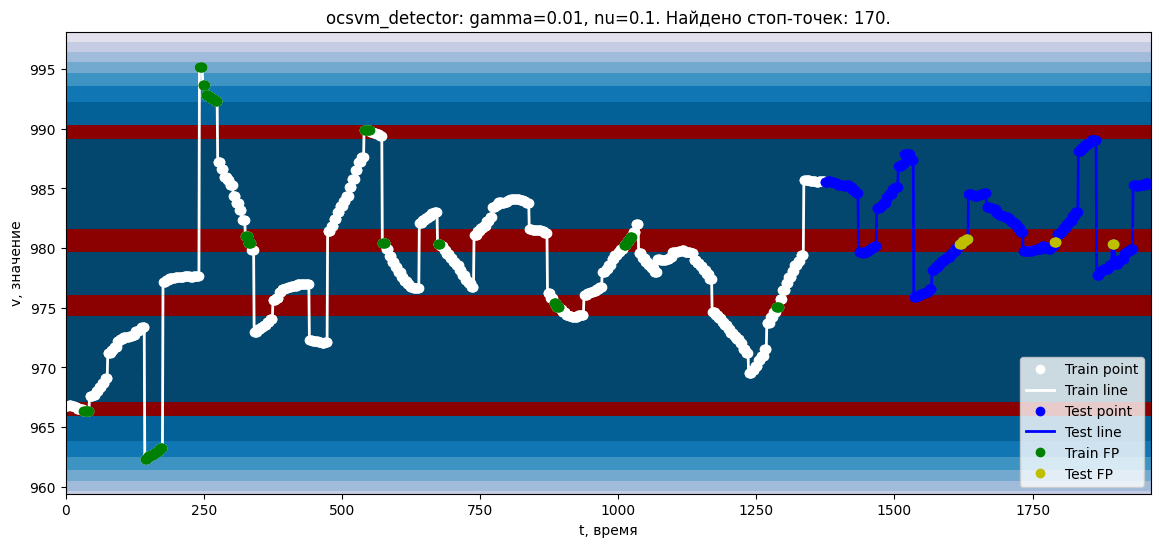

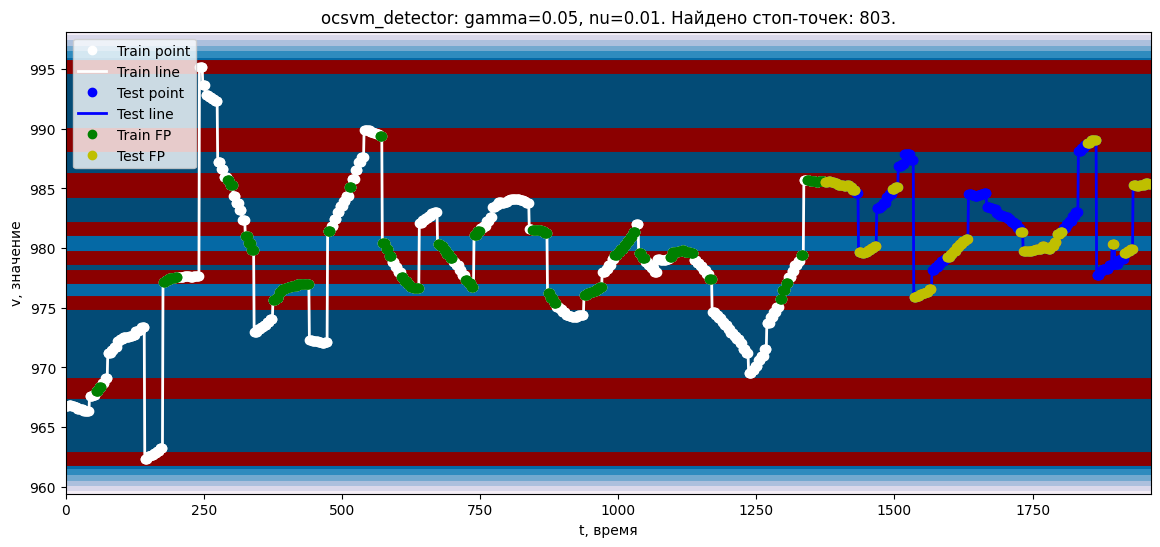

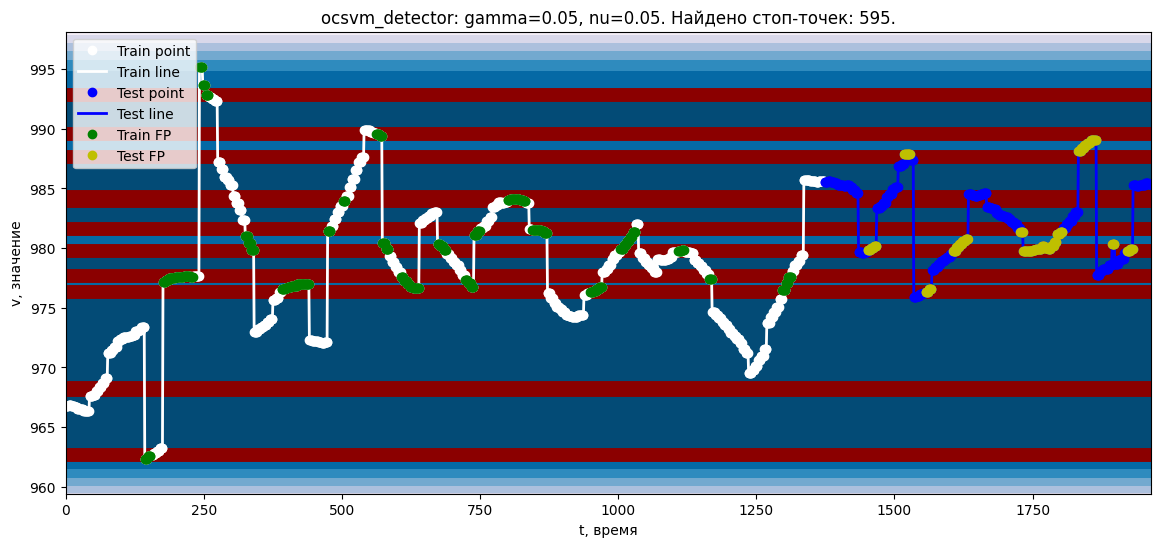

In [78]:
for gamma, nu in [ (0.01, 0.02), (0.01, 0.1), (0.05, 0.01), (0.05, 0.05)]:

  ocsvm_detector(y, gamma, nu)

Детектор имеет несколько настраиваемых параметров. Наиболее влияющие: gamma - коэффициент обучения и nu - верхняя граница доли ошибок обучения и нижняя граница доли опорных векторов.

При gamma = 0.01 опорных плоскостей 4, при этом nu влияет главным образом на попадание тренировочных значений на эти плоскости в случае с nu = 0.1 и непопадание с nu = 0.01.

При gamma = 0.05 опорных плоскостей 6, влияние nu аналогично тому, что при gamma = 0.01.
В целом, детектор отличается от предыдущих, он позволяет строить диапазоны, в которые попадают оснновные значения. Выход за эти диапазоны является аномалией.

Детектор выделил отдельный диапазон для значений из основной аномалии, при этом есть и ложные срабатывания из-за того, что часть значений тестовой выборки не содержится в тренировочной. Трудно сравнивать его с предыдущими индикаторами, т.к. он построен на несколько ином принципе детекции. И хоть для данного временного ряда он показал себя не с лучшей стороны, на других рядах он может оказаться довольно полезным.